In [2]:
# !pip install -q statsmodels scikit-learn openpyxl prophet tensorflow-cpu

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

2025-04-28 01:35:32.560864: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745804132.804710      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745804132.898042      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator
import itertools
import random
# import tensorflow as tf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from prophet import Prophet
from statsmodels.tsa.stattools import adfuller
from warnings import filterwarnings
import logging
filterwarnings('ignore')

In [5]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
file_path = 'data/hiv_aids_data_ukraine_2014_2024_by_oblast.xlsx'
data = pd.read_excel(file_path)
data['date'] = pd.to_datetime(data['year'].astype(str) + ' ' + data['month'], format='%Y %B')
data.head()

,year,month,oblast,hiv_new,aids_new,aids_death,date
0,2014,january,Україна,1940.0,872.0,274.0,2014-01-01
1,2014,january,АР Крим,104.0,33.0,12.0,2014-01-01
2,2014,january,Вінницька,28.0,26.0,4.0,2014-01-01
3,2014,january,Волинська,9.0,8.0,0.0,2014-01-01
4,2014,january,Дніпропетровська,239.0,156.0,76.0,2014-01-01


In [ ]:
ukraine_data = data[data['oblast'] == 'Україна'].copy()
ukraine_data.loc[:, 'date'] = pd.to_datetime(ukraine_data['date'])
ukraine_data.set_index('date', inplace=True)
ukraine_data.index = ukraine_data.index.to_period('M')
ukraine_data = ukraine_data.asfreq('M')
hiv_cases = ukraine_data['hiv_new']
relative_data = pd.read_excel('data/relative_hiv_new_ukraine.xlsx')
relative_data.loc[:, 'date'] = pd.to_datetime(relative_data['date'])
relative_data.set_index('date', inplace=True)
relative_data.index = relative_data.index.to_period('M')
relative_data = relative_data.asfreq('M')
relative_data = relative_data['relative_hiv_new']

In [8]:
relative_data.tail()

date
2024-08    2.349455
2024-09    2.330559
2024-10    2.327409
2024-11    1.980975
2024-12    2.632901
Freq: M, Name: relative_hiv_new, dtype: float64

In [9]:
def plot_time_series(data, title, xlabel="Date", ylabel="Values"):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(data.index.to_timestamp(), data.values, linestyle='-', color='tab:blue')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(linestyle='--')
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.tight_layout()
    plt.show()

In [10]:
def apply_detrending(data):
    """Detrend a series with a 2nd order polynomial."""
    X = np.arange(len(data)).reshape(-1, 1)
    X_poly = np.hstack([X, X**2])
    trend_model = LinearRegression().fit(X_poly, data.values)
    trend = trend_model.predict(X_poly)
    data_detrended = data.values - trend
    return pd.Series(data_detrended, index=data.index), trend_model

def apply_deseasoning(data, seasonality_period=12):
    """Deseason a series by subtracting monthly means."""
    seasonal_means = data.groupby(data.index.month).mean()
    data_deseasoned = []
    for idx, t in enumerate(data.index):
        month = t.month
        data_deseasoned.append(data.iloc[idx] - seasonal_means[month])
    return pd.Series(data_deseasoned, index=data.index), seasonal_means

def revert_deseasoning(data_deseasoned, seasonal_means):
    """Revert deseasoning by adding monthly means."""
    data_reseasoned = []
    for idx, t in enumerate(data_deseasoned.index):
        month = t.month
        data_reseasoned.append(data_deseasoned.iloc[idx] + seasonal_means[month])
    return pd.Series(data_reseasoned, index=data_deseasoned.index)

def revert_detrending(data_reseasoned, trend_model):
    """Revert detrending by adding back polynomial trend."""
    X = np.arange(len(data_reseasoned)).reshape(-1, 1)
    X_poly = np.hstack([X, X**2])
    trend = trend_model.predict(X_poly)
    data_final = data_reseasoned.values + trend
    return pd.Series(data_final, index=data_reseasoned.index)

In [11]:
train = relative_data[:'2021-01']
val = relative_data['2021-02':'2022-01']
test = relative_data['2022-02':]

In [12]:
def smape(actual, forecast):
    actual = np.array(actual)
    forecast = np.array(forecast)
    return 100 / len(actual) * np.sum(2 * np.abs(forecast - actual) / (np.abs(actual) + np.abs(forecast)))

In [13]:
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data.iloc[i:i+window_size].values)
        y.append(data.iloc[i+window_size])
    return np.array(X), np.array(y)

In [14]:
train_detrended, train_trend_model = apply_detrending(train)
train_deseasoned, train_seasonal_means = apply_deseasoning(train_detrended)
train_val_detrended, train_val_trend_model = apply_detrending(pd.concat([train,val]))
train_val_deseasoned, train_val_seasonal_means = apply_deseasoning(train_val_detrended)

In [88]:
import tensorflow.keras.backend as K
def smape_loss(y_true, y_pred):
    return K.mean(2 * K.abs(y_pred - y_true) / (K.abs(y_true) + K.abs(y_pred) + K.epsilon()))

In [ ]:
def get_lstm_prediction(train_data, num_layers, units, dropout, activation, pred_idx, seasonal_means, trend_model, window_size=24):
    """Train LSTM model and predict future values."""
    # LSTM data preparation and training
    X_train, y_train = create_sequences(train_data, window_size)
    X_train = X_train[..., np.newaxis]

    model = Sequential()
    if num_layers > 1:
        model.add(LSTM(units, activation=activation, dropout=dropout, input_shape=(window_size, 1), return_sequences=True))
        for _ in range(num_layers - 2):
            model.add(LSTM(units, activation=activation, dropout=dropout, return_sequences=True))
        
        model.add(LSTM(units, activation=activation, dropout=dropout))
    else:
        model.add(LSTM(units, activation=activation, dropout=dropout, input_shape=(window_size, 1)))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss=smape_loss)
    model.fit(X_train, y_train, epochs=250, batch_size=32, verbose=0)
    
    # LSTM predicting
    last_train_window = train_data[-window_size:].values
    current_batch = last_train_window.reshape((window_size, 1))
    n_predictions = len(pred_idx)
    dynamic_predictions = []
    
    for _ in range(n_predictions):
        pred = model.predict(current_batch[np.newaxis, ...])[0, 0]
        dynamic_predictions.append(pred)
        current_batch = np.append(current_batch[1:], [[pred]], axis=0)
    
    pred_series = pd.Series(dynamic_predictions, index=pred_idx)
    
    # Revert transformations
    pred_reseasoned = revert_deseasoning(pred_series, seasonal_means)
    pred_final = revert_detrending(pred_reseasoned, trend_model)
    return pred_final

In [ ]:
def tune_lstm(train_data, num_layers_list, units_list, dropout_list, activation_list, y, seasonal_means, trend_model, window_size=24):
    """Tune LSTM hyperparameters and return results."""
    results = []
    for num_layers, units, dropout, activation in itertools.product(num_layers_list, units_list, dropout_list, activation_list):
        res = get_lstm_prediction(train_data, num_layers, units, dropout, activation, y.index, seasonal_means, trend_model)
        mape = round(mean_absolute_percentage_error(res.values, y.values), 4)
        smape_val = round(smape(res.values, y.values) / 100, 4)
        rmse = round(np.sqrt(mean_squared_error(res.values, y.values)), 4)
        results.append({
            'num_layers': num_layers,
            'units': units,
            'dropout': dropout,
            'activation': activation,
            'mape': mape,
            'smape': smape_val,
            'rmse': rmse
        })
    return results

In [109]:
num_layers_list = [1, 2, 3]
units_list = [50, 60, 80, 100]
dropout_list = [0.1, 0.15, 0.2]
activation_list = ['tanh', 'relu']

In [110]:
val_results = tune_lstm(train_deseasoned, num_layers_list, units_list, dropout_list, 
                        activation_list, val, train_seasonal_means, train_trend_model, window_size=24)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━

In [112]:
val_results_df = pd.DataFrame(val_results)
val_results_df.sort_values(by='smape', ascending=True, inplace=True)
val_results_df.reset_index(drop=True, inplace=True)

In [114]:
val_results_df.head()

,num_layers,units,dropout,activation,mape,smape,rmse
0,1,60,0.2,relu,0.0864,0.0889,0.3630
1,1,100,0.1,tanh,0.0961,0.0937,0.3502
2,3,100,0.1,relu,0.0986,0.0969,0.3627
3,1,100,0.2,relu,0.0985,0.0973,0.3674
4,1,80,0.1,relu,0.1000,0.0978,0.3639


In [151]:
best_forecast_lstm = get_lstm_prediction(train_val_deseasoned, 1, 60, 0.2, 'relu', test.index, train_val_seasonal_means, train_val_trend_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━

In [ ]:
def plot_forcasted(actual, models_forecasts, title):
    """Plot actual vs forecasted values."""
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(actual.index.to_timestamp(), actual.values, label='Actual', color='tab:blue')
    tab_colors = plt.get_cmap('tab10')
    for i, (model, forecast) in enumerate(models_forecasts.items()):
        ax.plot(forecast.index.to_timestamp(), forecast.values, label=model, color=tab_colors(i+1), linestyle='--')
    ax.set_title(title)
    ax.set_xlabel("Date")
    ax.set_ylabel("Values")
    ax.legend()
    ax.grid(linestyle='--')
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.tight_layout()
    plt.show()


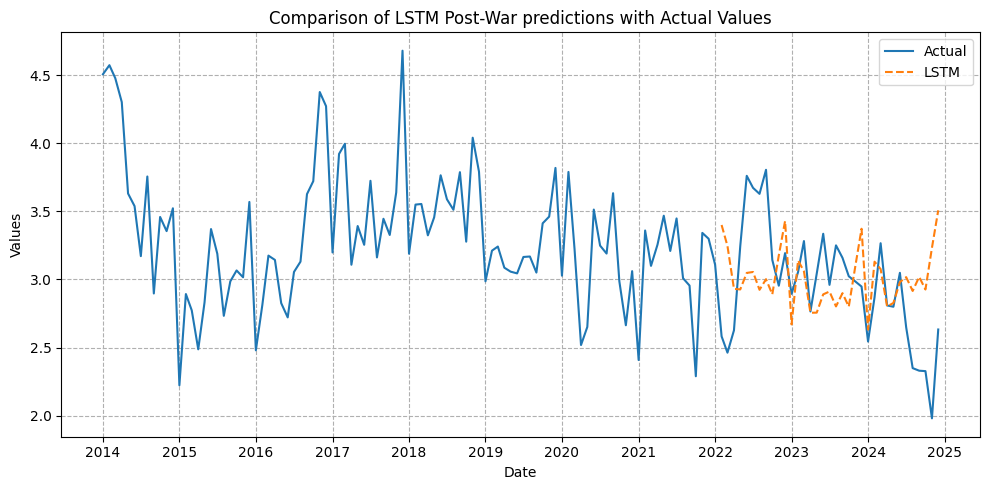

In [162]:
plot_forcasted(pd.concat([train, val, test]), {'LSTM': best_forecast_lstm}, 
                title="Comparison of LSTM Post-War predictions with Actual Values")


In [161]:
mean_absolute_percentage_error(test.values, best_forecast_lstm.values)

0.13854484821290816

In [159]:
rmse_lstm = np.sqrt(mean_squared_error(test.values, best_forecast_lstm.values))
mape_lstm = mean_absolute_percentage_error(test.values, best_forecast_lstm.values)
smape_lstm = smape(test.values, best_forecast_lstm.values)
results_test = pd.DataFrame({
    'Model': ['LSTM'],
    'MAPE': [mape_lstm],
    'SMAPE': [smape_lstm],
    'RMSE': [rmse_lstm]
})

In [160]:
results_test

,Model,MAPE,SMAPE,RMSE
0,LSTM,0.138545,13.033545,0.487123


In [164]:
best_forecast_lstm_df = pd.DataFrame(best_forecast_lstm, columns=['forecast_value'])

In [166]:
best_forecast_lstm_df.to_csv('best_forecast_lstm.csv', index=True)